In [35]:
import matplotlib.pyplot as plt
import numpy as np
import json
import os

def load_json(file_path):
    """Load and return a JSON object from a file."""
    try:
        with open(file_path, 'r') as f:
            data = json.load(f)
        return data
    except FileNotFoundError:
        print(f"Error: File not found -> {file_path}")
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON in file {file_path}: {e}")
    return None


def update_json(data, key, value): # Modify/Add Data
    data[key] = value
    return data

def save_json(file_path, data): # Save JSON Data
    with open(file_path, "w", encoding="utf-8") as f:
        json.dump(data, f, indent=4)

In [61]:
# creates a chart with the interpretation selections of Chat GPT, Llama and the Rwp minimization
#includes synthesis, interpretation info, balance score, Rwp, and likelihoods for each LLM

def find_all_choices(json_file, sample):
    sample_choice = {}
    if 1 == 1:
        llama_probs = []
        chat_probs = []
        rwp_vals = []
        sample_choice[sample] = {}
        for interpret, info in json_file[sample].items():
            if interpret == "Synth_Conditions":
                continue
            try:
                llama_score = info["unnormalized_posterior_llama"]
                chat_score = info["unnormalized_posterior"]
                rwp = info["rwp"]
                if all(isinstance(x, (int, float)) for x in [llama_score, chat_score, rwp]):
                    llama_probs.append((interpret, llama_score))
                    chat_probs.append((interpret, chat_score))
                    rwp_vals.append((interpret, rwp))
            except KeyError as e:
                print(f"Missing key in sample '{sample}', interpretation '{interpret}': {e}")
        
        sample_choice[sample]["llama_choice"] = max(llama_probs, key=lambda x: x[1])[0] if llama_probs else None
        sample_choice[sample]["chat_choice"] = max(chat_probs, key=lambda x: x[1])[0] if chat_probs else None
        sample_choice[sample]["rwp_choice"] = min(rwp_vals, key=lambda x: x[1])[0] if rwp_vals else None
    
    return sample_choice
file_path = "/Users/admin/Documents/GitHub/LLM_XRD_Interpretation_Validation/Data/prompt3/interpretations_llm_v1_llama1.json"
json_file = load_json(file_path)
find_all_choices(json_file, "ARR_39")

{'ARR_39': {'llama_choice': 'I_2', 'chat_choice': 'I_1', 'rwp_choice': 'I_1'}}

In [65]:
import pandas as pd
file_path = "/Users/admin/Documents/GitHub/LLM_XRD_Interpretation_Validation/Data/prompt3/interpretations_llm_v1_llama1.json"
json_file = load_json(file_path)
#sample_id = 'ARR_39'  # sample name

def format_predicted_phases(json_file, sample_id, chat_choice): 
    # Format the predicted phases with the weight fraction to be used in a table
    phases = json_file[sample_id][chat_choice]["phases"]
    wfs = json_file[sample_id][chat_choice]["weight_fraction"]
    wfs = [round(wf, 3) for wf in wfs]
    phase_list = ""
    for i in range(len(phases)):
        if not phase_list:
            phase_list += f"({phases[i]} {wfs[i]}%)"
        else: phase_list += f", ({phases[i]} {wfs[i]}%)"
    return phase_list

# Helper function to extract values safely
def assemble_df(sample_id, sample_choice, json_file):
    rows = []
    # assign Chat GPT row values
    chat_row = {}
    chat_choice = sample_choice[sample_id]["chat_choice"]
    chat_row["Selection Method"] = "Chat GPT"
    chat_row["Choice"] = chat_choice
    chat_row["Predicted Phases"] = format_predicted_phases(json_file, sample_id, chat_choice)
    chat_row["Balance Score"] = json_file[sample_id][chat_choice]["balance_score"]
    chat_row["Rwp"] = json_file[sample_id][chat_choice]["rwp"]
    chat_row["Chat GPT Likelihood"] = json_file[sample_id][chat_choice]["LLM_interpretation_likelihood"]
    chat_row["Llama Likelihood"] = json_file[sample_id][chat_choice]["LLM_interpretation_likelihood_llama"]

    #assign Llama row values
    llama_row = {}
    llama_choice = sample_choice[sample_id]["llama_choice"]
    llama_row["Selection Method"] = "Llama"
    llama_row["Choice"] = llama_choice
    llama_row["Predicted Phases"] = format_predicted_phases(json_file, sample_id, llama_choice)
    llama_row["Balance Score"] = json_file[sample_id][llama_choice]["balance_score"]
    llama_row["Rwp"] = json_file[sample_id][llama_choice]["rwp"]
    llama_row["Chat GPT Likelihood"] = json_file[sample_id][llama_choice]["LLM_interpretation_likelihood"]
    llama_row["Llama Likelihood"] = json_file[sample_id][llama_choice]["LLM_interpretation_likelihood_llama"]

    #assign lowest Rwp values
    rwp_row = {}
    rwp_choice = sample_choice[sample_id]["rwp_choice"]
    rwp_row["Selection Method"] = "Lowest Rwp"
    rwp_row["Choice"] = rwp_choice
    rwp_row["Predicted Phases"] = format_predicted_phases(json_file, sample_id, rwp_choice)
    rwp_row["Balance Score"] = json_file[sample_id][rwp_choice]["balance_score"]
    rwp_row["Rwp"] = json_file[sample_id][rwp_choice]["rwp"]
    rwp_row["Chat GPT Likelihood"] = json_file[sample_id][rwp_choice]["LLM_interpretation_likelihood"]
    rwp_row["Llama Likelihood"] = json_file[sample_id][rwp_choice]["LLM_interpretation_likelihood_llama"]
    rows = [chat_row, llama_row, rwp_row]
    return rows

for sample_id in json_file.keys(): # go through every sample and display a chart with relevant information 
    sample_choice = find_all_choices(json_file, sample_id)
    rows = assemble_df(sample_id, sample_choice, json_file)
    pd.set_option('display.max_colwidth', None)
    df = "df" + sample_id
    df = pd.DataFrame(rows)
    df = df[["Selection Method", "Choice", "Predicted Phases", "Balance Score", "Rwp", "Chat GPT Likelihood", "Llama Likelihood"]]
    print(sample_id)
    display(df)


PG_1048_1


,Selection Method,Choice,Predicted Phases,Balance Score,Rwp,Chat GPT Likelihood,Llama Likelihood
0,Chat GPT,I_3,"(V2O5_59 51.188%), (V3Cr7O15_167 48.812%), (Cr2O3_167 0.0%)",0.9744,4.74,0.70,0.8
1,Llama,I_3,"(V2O5_59 51.188%), (V3Cr7O15_167 48.812%), (Cr2O3_167 0.0%)",0.9744,4.74,0.70,0.8
2,Lowest Rwp,I_1,"(V20CrO52_59 4.341%), (V3Cr7O15_167 46.84%), (Cr2O3_167 0.0%), (V2O5_59 48.82%)",0.9711,4.60,0.55,0.6


ARR_39


,Selection Method,Choice,Predicted Phases,Balance Score,Rwp,Chat GPT Likelihood,Llama Likelihood
0,Chat GPT,I_1,(Ga33O50_12 100.0%),0.375,20.11,0.35,0.4
1,Llama,I_2,(Ga2O3_12 100.0%),0.375,20.14,0.35,0.6
2,Lowest Rwp,I_1,(Ga33O50_12 100.0%),0.375,20.11,0.35,0.4


TRI_62


,Selection Method,Choice,Predicted Phases,Balance Score,Rwp,Chat GPT Likelihood,Llama Likelihood
0,Chat GPT,I_7,"(Li14V43O114_11 78.118%), (LiVO3_15 21.882%)",0.998889,4.36,0.75,0.92
1,Llama,I_7,"(Li14V43O114_11 78.118%), (LiVO3_15 21.882%)",0.998889,4.36,0.75,0.92
2,Lowest Rwp,I_7,"(Li14V43O114_11 78.118%), (LiVO3_15 21.882%)",0.998889,4.36,0.75,0.92


TRI_84


,Selection Method,Choice,Predicted Phases,Balance Score,Rwp,Chat GPT Likelihood,Llama Likelihood
0,Chat GPT,I_2,"(K10V21O57_100 62.947%), (V2O5_11 19.204%), (KV3O8_11 17.849%)",0.9375,14.07,0.50,0.5
1,Llama,I_3,"(K10V21O57_100 63.677%), (KV3O8_11 36.323%)",0.9600,15.00,0.45,0.7
2,Lowest Rwp,I_2,"(K10V21O57_100 62.947%), (V2O5_11 19.204%), (KV3O8_11 17.849%)",0.9375,14.07,0.50,0.5


TRI_80


,Selection Method,Choice,Predicted Phases,Balance Score,Rwp,Chat GPT Likelihood,Llama Likelihood
0,Chat GPT,I_1,"(V2O3_167 59.694%), (CaCO3_167 40.306%)",0.995556,6.18,0.65,0.70
1,Llama,I_1,"(V2O3_167 59.694%), (CaCO3_167 40.306%)",0.995556,6.18,0.65,0.70
2,Lowest Rwp,I_3,"(V2O3_15 61.165%), (CaCO3_167 38.835%)",0.996789,5.86,0.55,0.55


PG_0849_1


,Selection Method,Choice,Predicted Phases,Balance Score,Rwp,Chat GPT Likelihood,Llama Likelihood
0,Chat GPT,I_2,"(WO3_14 63.778%), (CoWO4_13 36.222%)",0.8976,7.32,0.85,0.72
1,Llama,I_2,"(WO3_14 63.778%), (CoWO4_13 36.222%)",0.8976,7.32,0.85,0.72
2,Lowest Rwp,I_1,"(WO3_2 69.276%), (CoWO4_13 30.724%)",0.8775,6.30,0.75,0.70


TRI_81


,Selection Method,Choice,Predicted Phases,Balance Score,Rwp,Chat GPT Likelihood,Llama Likelihood
0,Chat GPT,I_2,(LiV3O8_11 100.0%),0.9375,6.91,0.75,0.92
1,Llama,I_2,(LiV3O8_11 100.0%),0.9375,6.91,0.75,0.92
2,Lowest Rwp,I_3,"(Li14V43O114_11 85.12%), (Li4CO5_15 14.88%)",0.9804,5.46,0.60,0.60


TRI_90


,Selection Method,Choice,Predicted Phases,Balance Score,Rwp,Chat GPT Likelihood,Llama Likelihood
0,Chat GPT,I_1,"(V2O3_167 81.771%), (Ca5V3O13_176 18.229%)",0.950122,10.19,0.60,0.85
1,Llama,I_1,"(V2O3_167 81.771%), (Ca5V3O13_176 18.229%)",0.950122,10.19,0.60,0.85
2,Lowest Rwp,I_3,"(V2O3_15 66.51%), (Ca5V3O13_176 33.49%)",0.984789,9.99,0.55,0.80


TRI_106


,Selection Method,Choice,Predicted Phases,Balance Score,Rwp,Chat GPT Likelihood,Llama Likelihood
0,Chat GPT,I_2,(V2O3_167 100.0%),0.375,18.50,0.50,0.95
1,Llama,I_1,"(V2O3_167 59.176%), (CO_194 40.824%)",0.375,15.59,0.25,0.90
2,Lowest Rwp,I_3,"(V2O3_15 58.666%), (CO_194 41.334%)",0.375,15.33,0.20,0.60


TRI_114


,Selection Method,Choice,Predicted Phases,Balance Score,Rwp,Chat GPT Likelihood,Llama Likelihood
0,Chat GPT,I_1,"(Li3VO4_31 41.013%), (V2O3_167 35.586%), (V4O7_2 23.401%)",0.9639,6.92,0.85,0.65
1,Llama,I_4,"(Li3VO4_31 42.512%), (V2O3_15 38.648%), (V4O7_2 18.84%)",0.9676,6.29,0.82,0.70
2,Lowest Rwp,I_4,"(Li3VO4_31 42.512%), (V2O3_15 38.648%), (V4O7_2 18.84%)",0.9676,6.29,0.82,0.70


TRI_183


,Selection Method,Choice,Predicted Phases,Balance Score,Rwp,Chat GPT Likelihood,Llama Likelihood
0,Chat GPT,I_4,"(Mg2V2O7_2 62.342%), (MgV2O6_12 37.658%)",0.9964,6.34,0.85,0.8
1,Llama,I_4,"(Mg2V2O7_2 62.342%), (MgV2O6_12 37.658%)",0.9964,6.34,0.85,0.8
2,Lowest Rwp,I_1,"(Mg2V2O7_2 31.416%), (MgV2O6_12 61.499%), (VO2_58 7.085%)",0.9804,6.14,0.75,0.8


TRI_41


,Selection Method,Choice,Predicted Phases,Balance Score,Rwp,Chat GPT Likelihood,Llama Likelihood
0,Chat GPT,I_2,(Li14V43O114_11 100.0%),1,5.39,0.6,0.00
1,Llama,I_1,(LiV3O8_11 100.0%),1,5.81,0.6,0.95
2,Lowest Rwp,I_2,(Li14V43O114_11 100.0%),1,5.39,0.6,0.00


TRI_87


,Selection Method,Choice,Predicted Phases,Balance Score,Rwp,Chat GPT Likelihood,Llama Likelihood
0,Chat GPT,I_5,"(CaC2_2 29.148%), (Ca5V3O13_176 21.802%), (V9O17_2 18.774%), (CaCO3_167 15.794%), (V2O5_15 14.482%)",0.9919,18.54,0.75,0.65
1,Llama,I_5,"(CaC2_2 29.148%), (Ca5V3O13_176 21.802%), (V9O17_2 18.774%), (CaCO3_167 15.794%), (V2O5_15 14.482%)",0.9919,18.54,0.75,0.65
2,Lowest Rwp,I_5,"(CaC2_2 29.148%), (Ca5V3O13_176 21.802%), (V9O17_2 18.774%), (CaCO3_167 15.794%), (V2O5_15 14.482%)",0.9919,18.54,0.75,0.65


ARR_46


,Selection Method,Choice,Predicted Phases,Balance Score,Rwp,Chat GPT Likelihood,Llama Likelihood
0,Chat GPT,I_3,"(Ti12O25_61 65.616%), (CaTi4(PO4)6_148 34.384%)",0.70930,7.22,0.60,0.65
1,Llama,I_3,"(Ti12O25_61 65.616%), (CaTi4(PO4)6_148 34.384%)",0.70930,7.22,0.60,0.65
2,Lowest Rwp,I_2,"(CaP2(HO2)4_2 70.209%), (Ti12O25_61 15.823%), (CaTi4(PO4)6_148 13.969%)",0.79164,6.91,0.35,0.25


TRI_105


,Selection Method,Choice,Predicted Phases,Balance Score,Rwp,Chat GPT Likelihood,Llama Likelihood
0,Chat GPT,I_1,"(V2O3_167 69.966%), (CaO_225 17.014%), (Ca5V3O13_176 13.02%)",0.993056,5.72,0.65,0.7
1,Llama,I_1,"(V2O3_167 69.966%), (CaO_225 17.014%), (Ca5V3O13_176 13.02%)",0.993056,5.72,0.65,0.7
2,Lowest Rwp,I_1,"(V2O3_167 69.966%), (CaO_225 17.014%), (Ca5V3O13_176 13.02%)",0.993056,5.72,0.65,0.7


In [80]:
import textwrap
file_path = "/Users/admin/Documents/GitHub/LLM_XRD_Interpretation_Validation/Data/prompt3/interpretations_llm_v1_llama1.json"
json_file = load_json(file_path)
def print_synthconditions(sample_id,json_file):
    synth_conditions = json_file[sample_id]["Synth_Conditions"]
    target = synth_conditions["Target"]
    precursor1 = synth_conditions["Precursor 1"]
    precursor2 = synth_conditions["Precursor 2"]
    if "Precursor 3" in synth_conditions:
        precursor3 = synth_conditions["Precursor 3"]
    furnace = synth_conditions["Furnace"]
    tempc = synth_conditions["Temperature (C)"]
    tempk = synth_conditions["Temperature (K)"]
    dwell = synth_conditions["Dwell Duration (h)"]
    if "Precursor 3" in synth_conditions:
        print_conditions =textwrap.dedent(f"""
        Target: {target}
        Precursors: {precursor1}, {precursor2}, {precursor3}
        Furnace: {furnace}
        Temperature (C): {tempc}
        Temperature (K): {tempk}
        Dwell Duration (h): {dwell}
        """)
    else:
        print_conditions = textwrap.dedent(f"""
        Synthesis Conditions:                                   
        Target: {target}
        Precursors: {precursor1}, {precursor2}
        Furnace: {furnace}
        Temperature (C): {tempc}
        Temperature (K): {tempk}
        Dwell Duration (h): {dwell}
        """)
    return print_conditions
sample_id = "TRI_183"
print_conditions = print_synthconditions(sample_id,json_file)
print(print_conditions)


Synthesis Conditions:                                   
Target: MgVO3
Precursors: MgCO3, V2O5
Furnace: BF
Temperature (C): 500.0
Temperature (K): 773.15
Dwell Duration (h): 12.0



In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D

def find_choices(sample, json_file, model):
    #creates an ordered list of most favorable interpretations for both the LLM model and Rwp values
    rwp_vals = []
    model_scores = []
    for interpret, info in json_file[sample].items():
        if interpret == "Synth_Conditions":
            continue
        rwp = info["rwp"]
        if model == "Llama":
            model_score = info["unnormalized_posterior_llama"]
        if model == "Chat GPT":
            model_score = info["unnormalized_posterior"]
        rwp_vals.append((interpret, rwp))
        model_scores.append((interpret, model_score))
    sample_choice_rwp = sorted(rwp_vals, key=lambda x: x[1])
    sample_choice_rwp = [i[0] for i in sample_choice_rwp]
    sample_choice_model = sorted(model_scores, key=lambda x: x[1],reverse=True)
    sample_choice_model = [i[0] for i in sample_choice_model]
    return [sample_choice_rwp, sample_choice_model]
def get_blues_colors(reference_list, skip_low=0.35):
    """
    Generate `n_phases` shades of blue from the 'Blues' colormap,
    skipping the low-saturation (lighter) colors at the bottom.
    
    Parameters:
        n_phases (int): Number of distinct blues to return.
        skip_low (float): Fraction of the colormap to skip from the bottom (0 to 1).
    
    Returns:
        list of hex colors
    """
    cmap = plt.get_cmap('Blues')
    n_phases = len(reference_list)
    # Sample evenly from the high-saturation portion only
    values = [skip_low + (1 - skip_low) * (i / (n_phases - 1)) for i in range(n_phases)]
    return [mcolors.to_hex(cmap(v)) for v in values]

def generate_colors(reference_list, cmap_name='Blues'):
    cmap = plt.get_cmap(cmap_name, len(reference_list))  # Discretize the colormap
    return [mcolors.to_hex(cmap(i)) for i in range(len(reference_list))]

def graph_interpretation_likelihoods(json_file, sample_id, model):
    # Interpretation names and probabilities
    interpretations = find_choices(sample_id, json_file, model)[1] #
    interpretations.reverse()
    #print(interpretations)
    probabilities = []
    phase_fractions = []
    phase_labels = []
    label_colors = []
    for interpret in interpretations:
        if model == "Llama": #collect llama probabilities 
            probabilities.append(round(json_file[sample_id][interpret]["posterior_probability_llama"],3)*100) 
        if model == "Chat GPT": #collect chat gpt probabilities
            probabilities.append(round(json_file[sample_id][interpret]["posterior_probability"],3)*100)
        wfs = json_file[sample_id][interpret]["weight_fraction"]
        wfs = [((round(i,2))*probabilities[-1]/100) for i in wfs]
        phase_fractions.append(wfs)
        phase_labels.append(json_file[sample_id][interpret]["phases"])

    # assign label colors based on if the LLM or Rwp minimization favors the Interpretation
    choices = find_choices(sample_id,json_file,model)
    for i in range(len(interpretations)): 
        if interpretations[i] == choices[1][0] and interpret == choices[0][0]:
            interpretations[i] = r"$^{\mathbf{*}}$ " + interpretations[i]
        elif interpretations[i] == choices[0][0]: 
            # Rwp minimum interpretation
            interpretations[i] = r"$^{\mathbf{*}}$ "+ interpretations[i]
        #elif interpretations[i] == choices[1][0]:

    # assign colors for each phase (colors are set for all interpretations)
    phases_total = []
    unordered_interprets = json_file[sample_id]
    for interpret, info in unordered_interprets.items():
        if interpret != "Synth_Conditions":
            for phase in info["phases"]:
                    if phase not in phases_total:
                        phases_total.append(phase)
    # create a dictionary with color bindings for each phase predicted in the sample
    phase_colors = dict(zip(phases_total, get_blues_colors(phases_total)))
    #print(phase_colors)
    # create a new list (of lists) with the color for each phase
    color_list = []
    for phases in phase_labels:
        color_interpret = []
        for phase in phases:
            color_interpret.append(phase_colors[phase])
        color_list.append(color_interpret)
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(7, 5))  # Wider for more space

    # Plot each interpretation as stacked horizontal bar
    for i in range(len(interpretations)):
        left = 0
        for j in range(len(phase_fractions[i])):
            width = phase_fractions[i][j]
            if width > 0:
                ax.barh(i, width, left=left, color=color_list[i][j], height=0.6)
                left += width

    # Add interpretation names inside the bar (or just left of the bar)
    for i, (name, prob) in enumerate(zip(interpretations, probabilities)):
        ax.text(-1, i, name, va='center', ha='right', fontweight='bold', fontsize=11, color="black")
        ax.text(prob + 1.5, i, f"{round(prob,3)}%", va='center', ha='left', fontsize=10)

    # Customize legend
    legend_handles = [Patch(color=phase_colors[phase], label=phase) for phase in phases_total]
    phase_legend = ax.legend(handles=legend_handles, loc='lower right', frameon=True, fontsize=9)
    ax.add_artist(phase_legend)

    # Axis and layout
    ax.set_xlim(0, max(probabilities) + 10)
    ax.set_yticks([])  # Remove y-axis ticks
    ax.set_xlabel(f'Interpretation Probability (%) Using {model}', fontsize=12, fontweight='bold')
    ax.grid(axis='x', linestyle='--', alpha=0.5)

    #add seperate legend to identify which framework selected which interpretation
    custom_legend_handles = [
        Line2D([], [], color='black', linestyle='None', label='* "dara" selection', markersize=10)
        ]

    ax.legend(
    handles=custom_legend_handles,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),  # X=50% center, Y=just below the plot
    ncol=2,
    frameon=False,
    fontsize=10
    )
    plt.tight_layout()
    plt.show()



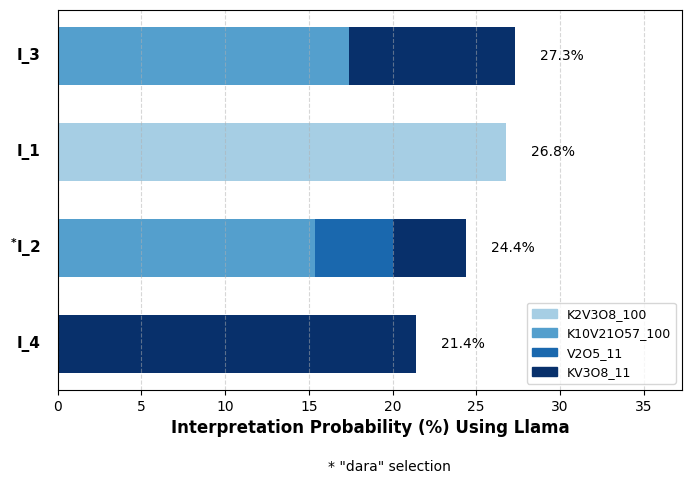

In [224]:
sample_id = "TRI_84"
model = "Llama"
graph_interpretation_likelihoods(json_file, sample_id, model)

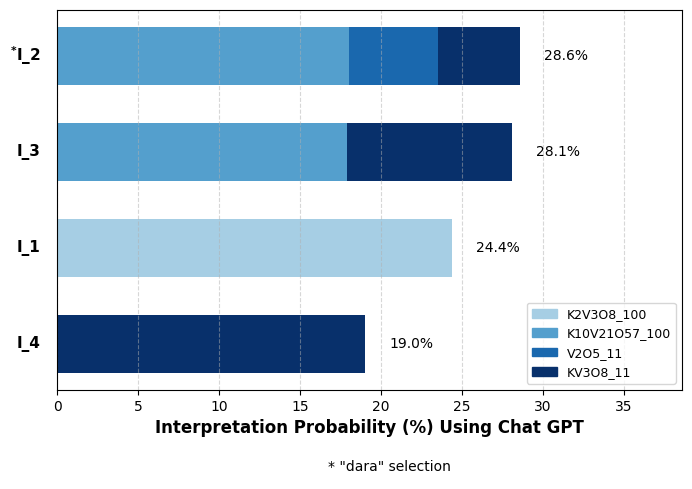

In [225]:
sample_id = "TRI_84"
model = "Chat GPT"
graph_interpretation_likelihoods(json_file, sample_id, model)